Часть 2: Базовая U-Net на датасете "Луна"
2.1 Загрузка данных сегментации

Требования к архитектуре U-Net (зафиксируйте и опишите в отчёте):
Глубина: 4 уровня down/4 up (энкодер-декодер с skip-связями).
Базовые каналы на первом уровне: 32 или 64 (по желанию можно выбрать свое количество каналов, но надо будет объяснить).
Даунсемплинг: stride 2 или MaxPool.
Итоговый слой: 1 канал с сигмоидой (бинарная сегментация).
Ограничение на количество параметров: до ~2.5M (рекомендуется укладываться, но допускается ±10%).
Вход: 128×128×3.
Обучение:
Лосс: BCEWithLogitsLoss или Dice Loss, допустимо комбинировать (например, 0.5BCE + 0.5Dice).
Метрики для мониторинга: IoU (Jaccard), Dice, Pixel Accuracy.
Аугментации: горизонтальные/вертикальные флипы, лёгкие геометрические и цветовые — по желанию (можно добавлять другие).
Что сдаём по части 2:
Логи обучения и итоговые метрики на валидации: IoU, Dice, Pixel Acc.
3–5 визуализаций: вход, предсказанная маска, GT маска.

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from tqdm import tqdm
import random

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
import torchvision
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder

from PIL import Image
import cv2
import albumentations as A
from albumentations.pytorch import ToTensorV2

from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split
import pandas as pd


In [2]:
!unzip -q /content/MOON_SEGMENTATION_BINARY.zip -d /content/

In [3]:
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')


MOON_DATA_PATH = '/content/MOON_SEGMENTATION_BINARY'
CHECKPOINT_DIR =  '/content/checkpoints'
os.makedirs(CHECKPOINT_DIR, exist_ok=True)

Using device: cuda


/usr/local/lib/python3.12/dist-packages/albumentations/core/validation.py:114: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)


Всего изображений: 1000
Train: 800 изображений
Val: 200 изображений


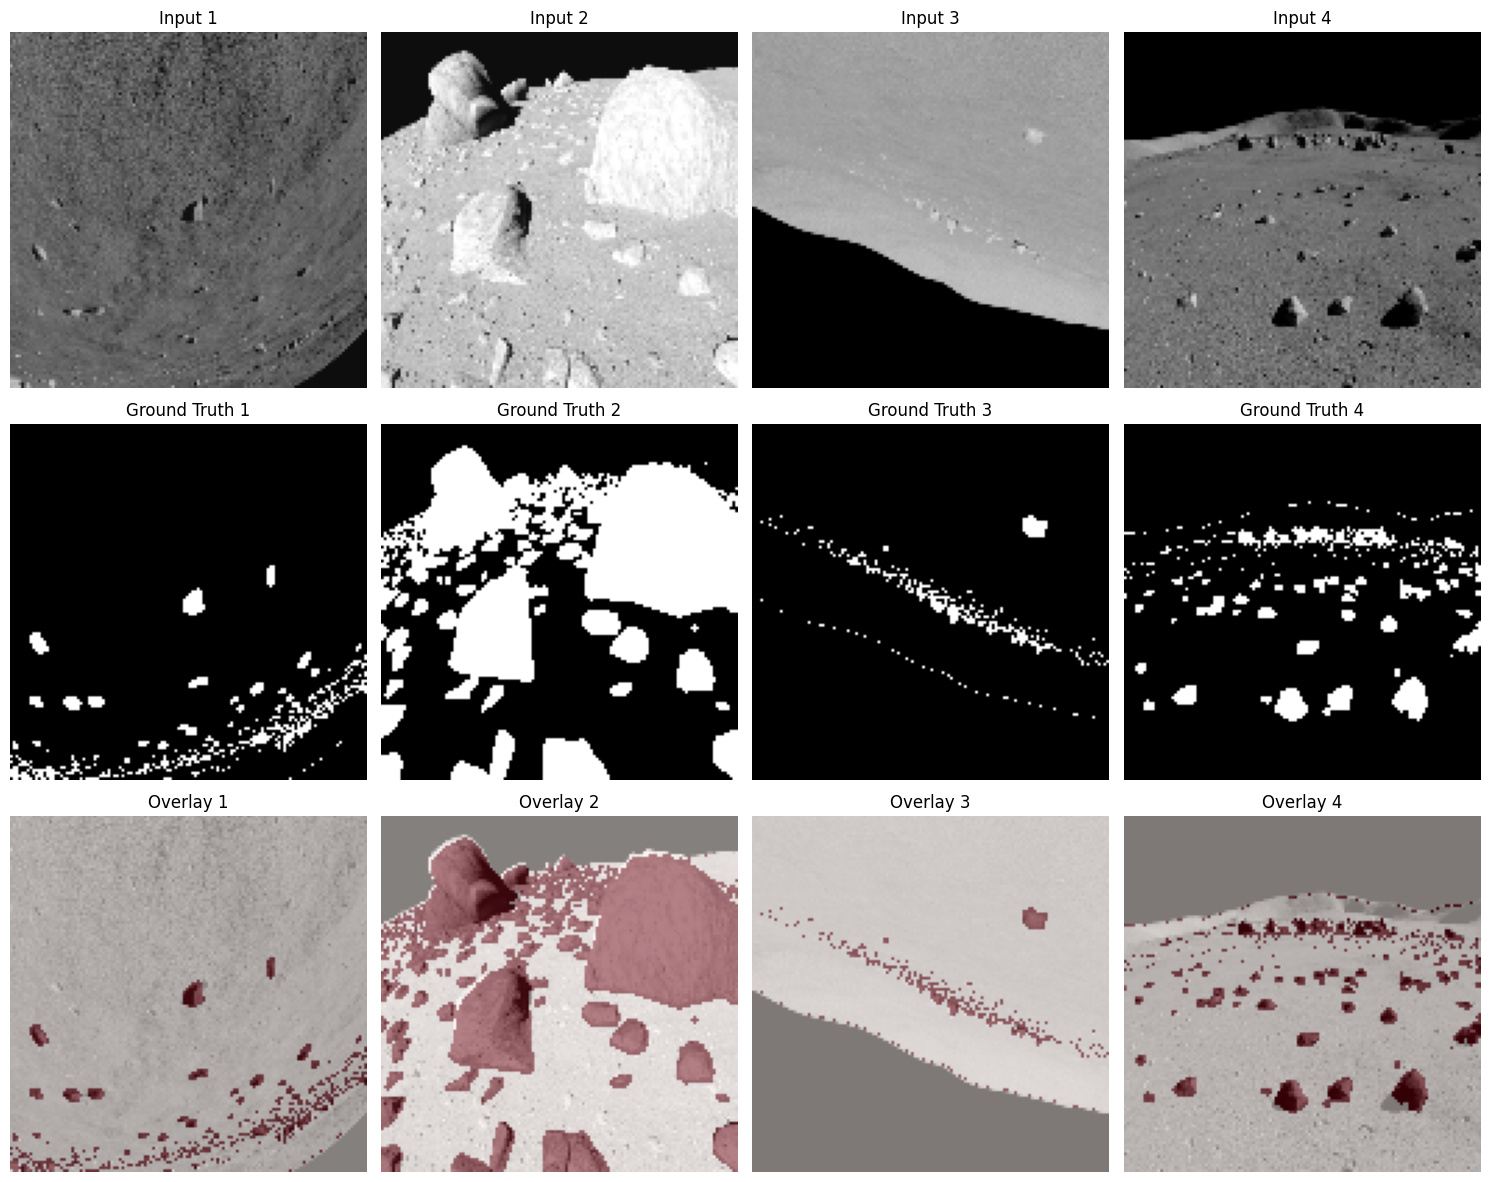

In [5]:
class MoonSegmentationDataset(Dataset):

    def __init__(self, root_dir, image_folder='render', mask_folder='ground',
                 image_ids=None, augmentation=None, preprocessing=None):
        self.root_dir = root_dir
        self.image_folder = image_folder
        self.mask_folder = mask_folder
        self.transform = augmentation
        self.preprocessing = preprocessing

        images_dir = os.path.join(root_dir, 'images', image_folder)
        all_images_names = os.listdir(images_dir)

        # Filter for .png files and remove extension
        self.image_ids = [img.replace('.png', '') for img in all_images_names if img.endswith('.png')]

        # If specific image_ids are provided, filter the loaded ones.
        if image_ids is not None:
            self.image_ids = [id for id in self.image_ids if id in image_ids]


    def __len__(self):
        return len(self.image_ids)

    def __getitem__(self, idx):
        image_id = self.image_ids[idx]

        image_path = os.path.join(self.root_dir, 'images', self.image_folder, f"{image_id}.png")

        # Adjusted mask_id construction based on observed file names
        # Assuming mask_id is just the number if image_id is 'renderXXXX'
        mask_number = ''.join(filter(str.isdigit, image_id))
        mask_path = os.path.join(self.root_dir, 'images', self.mask_folder, f"ground{mask_number}.png")

        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

        mask = (mask > 0).astype(np.float32)

        if self.transform:
            sample = self.transform(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']

        if self.preprocessing:
            sample = self.preprocessing(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']

        return image, mask

train_augmentation = A.Compose([
    A.Resize(128, 128), # Changed to 128x128
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.RandomRotate90(p=0.5),
    A.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.1, rotate_limit=45, p=0.5),
    A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=0.5),
])

preprocessing = A.Compose([
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ToTensorV2(),
])

val_augmentation = A.Compose([
    A.Resize(128, 128), # Changed to 128x128
])

def denormalize(img_tensor):
    mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
    std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
    return img_tensor * std + mean

images_dir = os.path.join(MOON_DATA_PATH, 'images', 'render')
all_images = [img.replace('.png', '') for img in os.listdir(images_dir) if img.endswith('.png')]

print(f"Всего изображений: {len(all_images)}")

train_ids, val_ids = train_test_split(all_images, test_size=0.2, random_state=42)

print(f"Train: {len(train_ids)} изображений")
print(f"Val: {len(val_ids)} изображений")

train_dataset = MoonSegmentationDataset(
    root_dir=MOON_DATA_PATH,
    image_folder='render',
    mask_folder='ground',
    image_ids=train_ids,
    augmentation=train_augmentation,
    preprocessing=preprocessing
)

val_dataset = MoonSegmentationDataset(
    root_dir=MOON_DATA_PATH,
    image_folder='render',
    mask_folder='ground',
    image_ids=val_ids,
    augmentation=val_augmentation,
    preprocessing=preprocessing
)

batch_size = 10

train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
)

val_loader = DataLoader(
    val_dataset,
    batch_size=batch_size,
    shuffle=False,
)

fig, axes = plt.subplots(3, 4, figsize=(15, 12))
for i in range(4):
    img, mask = train_dataset[i*10]

    img_display = denormalize(img)
    img_display = img_display.permute(1, 2, 0).numpy()
    img_display = np.clip(img_display, 0, 1)

    axes[0, i].imshow(img_display)
    axes[0, i].set_title(f'Input {i+1}')
    axes[0, i].axis('off')

    axes[1, i].imshow(mask.squeeze(), cmap='gray')
    axes[1, i].set_title(f'Ground Truth {i+1}')
    axes[1, i].axis('off')

    axes[2, i].imshow(img_display)
    axes[2, i].imshow(mask.squeeze(), cmap='Reds', alpha=0.5)
    axes[2, i].set_title(f'Overlay {i+1}')
    axes[2, i].axis('off')

plt.tight_layout()
plt.show()

2.2 Архитектура базовой U-Net

In [6]:
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DoubleConv, self).__init__()
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),

            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)

class UNet(nn.Module):

    def __init__(self, in_channels=3, out_channels=1, features=[64, 128, 256, 512]):
        super(UNet, self).__init__()

        self.encoder_blocks = nn.ModuleList()
        self.decoder_blocks = nn.ModuleList()

        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        prev_channels = in_channels
        for feature in features:
            self.encoder_blocks.append(DoubleConv(prev_channels, feature))
            prev_channels = feature

        self.bottleneck = DoubleConv(features[-1], features[-1] * 2)

        for feature in reversed(features):
            self.decoder_blocks.append(
                nn.ConvTranspose2d(feature * 2, feature, kernel_size=2, stride=2)
            )
            self.decoder_blocks.append(
                DoubleConv(feature * 2, feature)
            )

        self.final_conv = nn.Conv2d(features[0], out_channels, kernel_size=1)

        total_params = sum(p.numel() for p in self.parameters())
        print(f"Параметров: {total_params:,}")
        print(f"Уровней encoder: {len(features)}")
        print(f"Конфигурация каналов: {features}")

    def forward(self, x):

        skip_connections = []

        for encoder_block in self.encoder_blocks:
            x = encoder_block(x)
            skip_connections.append(x)
            x = self.pool(x)

        x = self.bottleneck(x)

        skip_connections = skip_connections[::-1]

        for idx in range(0, len(self.decoder_blocks), 2):
            x = self.decoder_blocks[idx](x)

            skip_connection = skip_connections[idx // 2]

            if x.shape != skip_connection.shape:
                x = F.interpolate(x, size=skip_connection.shape[2:],
                                mode='bilinear', align_corners=True)

            x = torch.cat([skip_connection, x], dim=1)

            x = self.decoder_blocks[idx + 1](x)

        output = self.final_conv(x)

        return output


model = UNet(in_channels=3, out_channels=1, features=[64, 128, 256, 512])

test_input = torch.randn(1, 3, 256, 256)
test_output = model(test_input)

print(f"   Вход:  {test_input.shape}")
print(f"   Выход: {test_output.shape}")

Параметров: 31,043,521
Уровней encoder: 4
Конфигурация каналов: [64, 128, 256, 512]
   Вход:  torch.Size([1, 3, 256, 256])
   Выход: torch.Size([1, 1, 256, 256])


In [30]:
total_params_unet = sum(p.numel() for p in model.parameters())
print(total_params_unet)

31043521


2.3 Функции потерь и метрики

In [7]:
class DiceLoss(nn.Module):
    def __init__(self, smooth=1.0):
        super(DiceLoss, self).__init__()
        self.smooth = smooth

    def forward(self, pred, target):
        pred = torch.sigmoid(pred)
        pred = pred.view(-1)
        target = target.view(-1)

        intersection = (pred * target).sum()
        dice = (2. * intersection + self.smooth) / (pred.sum() + target.sum() + self.smooth)

        return 1 - dice

class CombinedLoss(nn.Module):
    def __init__(self, bce_weight=0.5, dice_weight=0.5):
        super(CombinedLoss, self).__init__()
        self.bce_weight = bce_weight
        self.dice_weight = dice_weight
        self.bce = nn.BCEWithLogitsLoss()
        self.dice = DiceLoss()

    def forward(self, pred, target):
        bce_loss = self.bce(pred, target)
        dice_loss = self.dice(pred, target)
        return self.bce_weight * bce_loss + self.dice_weight * dice_loss

def calculate_iou(pred, target, threshold=0.5):
    pred = (torch.sigmoid(pred) > threshold).float()
    pred = pred.view(-1)
    target = target.view(-1)

    intersection = (pred * target).sum()
    union = pred.sum() + target.sum() - intersection

    iou = (intersection + 1e-6) / (union + 1e-6)
    return iou.item()

def calculate_dice(pred, target, threshold=0.5):
    pred = (torch.sigmoid(pred) > threshold).float()
    pred = pred.view(-1)
    target = target.view(-1)

    intersection = (pred * target).sum()
    dice = (2. * intersection + 1e-6) / (pred.sum() + target.sum() + 1e-6)

    return dice.item()

def calculate_pixel_accuracy(pred, target, threshold=0.5):
    pred = (torch.sigmoid(pred) > threshold).float()
    correct = (pred == target).float().sum()
    total = target.numel()

    return (correct / total).item()

2.4 Обучение базовой U-Net

In [8]:
def train_unet(model, train_loader, val_loader, num_epochs=10, lr=0.001, model_name='unet'):
    criterion = CombinedLoss(bce_weight=0.5, dice_weight=0.5)
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=1e-4)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5,
                                                      patience=5)

    history = {
        'train_loss': [],
        'val_loss': [],
        'val_iou': [],
        'val_dice': [],
        'val_pixel_acc': []
    }

    best_val_iou = 0.0
    model.to(device)

    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0

        pbar = tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs} [Train]')
        for images, masks in pbar:
            images, masks = images.to(device), masks.to(device)
            masks = masks.unsqueeze(1) # Add channel dimension

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, masks)
            loss.backward()
            optimizer.step()

            train_loss += loss.item() * images.size(0)
            pbar.set_postfix({'loss': loss.item()})

        train_loss = train_loss / len(train_loader.dataset)

        model.eval()
        val_loss = 0.0
        val_iou_sum = 0.0
        val_dice_sum = 0.0
        val_pixel_acc_sum = 0.0

        with torch.no_grad():
            for images, masks in tqdm(val_loader, desc=f'Epoch {epoch+1}/{num_epochs} [Val]'):
                images, masks = images.to(device), masks.to(device)
                masks = masks.unsqueeze(1) # Add channel dimension
                outputs = model(images)
                loss = criterion(outputs, masks)

                val_loss += loss.item() * images.size(0)

                for i in range(outputs.size(0)):
                    val_iou_sum += calculate_iou(outputs[i], masks[i])
                    val_dice_sum += calculate_dice(outputs[i], masks[i])
                    val_pixel_acc_sum += calculate_pixel_accuracy(outputs[i], masks[i])

        val_loss = val_loss / len(val_loader.dataset)
        val_iou = val_iou_sum / len(val_loader.dataset)
        val_dice = val_dice_sum / len(val_loader.dataset)
        val_pixel_acc = val_pixel_acc_sum / len(val_loader.dataset)

        scheduler.step(val_iou)

        history['train_loss'].append(train_loss)
        history['val_loss'].append(val_loss)
        history['val_iou'].append(val_iou)
        history['val_dice'].append(val_dice)
        history['val_pixel_acc'].append(val_pixel_acc)

        print(f'Epoch {epoch+1}/{num_epochs}:')
        print(f'  Train Loss: {train_loss:.4f}')
        print(f'  Val Loss: {val_loss:.4f}')
        print(f'  Val IoU: {val_iou:.4f}, Dice: {val_dice:.4f}, Pixel Acc: {val_pixel_acc:.4f}')
        print(f'  LR: {optimizer.param_groups[0]['lr']:.6f}')

        if val_iou > best_val_iou:
            best_val_iou = val_iou
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'val_iou': val_iou,
                'val_dice': val_dice,
                'val_pixel_acc': val_pixel_acc,
            }, os.path.join(CHECKPOINT_DIR, f'best_{model_name}.pth'))
            print(f'Best model saved! (Val IoU: {val_iou:.4f})')

        print()

    return history

history_unet_basic = train_unet(model, train_loader, val_loader,
                                num_epochs=10, lr=0.001, model_name='unet_basic')

Epoch 1/10 [Val]: 100%|██████████| 20/20 [00:03<00:00,  6.07it/s]


Epoch 1/10:
  Train Loss: 0.5366
  Val Loss: 0.4466
  Val IoU: 0.2663, Dice: 0.4010, Pixel Acc: 0.8997
  LR: 0.001000
Best model saved! (Val IoU: 0.2663)



Epoch 2/10 [Val]: 100%|██████████| 20/20 [00:03<00:00,  6.20it/s]


Epoch 2/10:
  Train Loss: 0.4540
  Val Loss: 0.4281
  Val IoU: 0.2884, Dice: 0.4265, Pixel Acc: 0.8916
  LR: 0.001000
Best model saved! (Val IoU: 0.2884)



Epoch 3/10 [Val]: 100%|██████████| 20/20 [00:03<00:00,  5.49it/s]


Epoch 3/10:
  Train Loss: 0.4240
  Val Loss: 0.4180
  Val IoU: 0.2966, Dice: 0.4379, Pixel Acc: 0.9049
  LR: 0.001000
Best model saved! (Val IoU: 0.2966)



Epoch 4/10 [Val]: 100%|██████████| 20/20 [00:03<00:00,  5.50it/s]


Epoch 4/10:
  Train Loss: 0.4092
  Val Loss: 0.3858
  Val IoU: 0.3057, Dice: 0.4401, Pixel Acc: 0.9146
  LR: 0.001000
Best model saved! (Val IoU: 0.3057)



Epoch 5/10 [Val]: 100%|██████████| 20/20 [00:03<00:00,  6.03it/s]


Epoch 5/10:
  Train Loss: 0.4005
  Val Loss: 0.3853
  Val IoU: 0.3265, Dice: 0.4712, Pixel Acc: 0.9147
  LR: 0.001000
Best model saved! (Val IoU: 0.3265)



Epoch 6/10 [Val]: 100%|██████████| 20/20 [00:03<00:00,  5.30it/s]


Epoch 6/10:
  Train Loss: 0.3968
  Val Loss: 0.4080
  Val IoU: 0.3030, Dice: 0.4448, Pixel Acc: 0.9090
  LR: 0.001000



Epoch 7/10 [Val]: 100%|██████████| 20/20 [00:03<00:00,  6.11it/s]


Epoch 7/10:
  Train Loss: 0.3954
  Val Loss: 0.3780
  Val IoU: 0.3428, Dice: 0.4876, Pixel Acc: 0.9009
  LR: 0.001000
Best model saved! (Val IoU: 0.3428)



Epoch 8/10 [Val]: 100%|██████████| 20/20 [00:03<00:00,  6.08it/s]


Epoch 8/10:
  Train Loss: 0.4008
  Val Loss: 0.4077
  Val IoU: 0.3128, Dice: 0.4553, Pixel Acc: 0.8975
  LR: 0.001000



Epoch 9/10 [Val]: 100%|██████████| 20/20 [00:03<00:00,  6.05it/s]


Epoch 9/10:
  Train Loss: 0.3902
  Val Loss: 0.3735
  Val IoU: 0.3492, Dice: 0.4954, Pixel Acc: 0.9149
  LR: 0.001000
Best model saved! (Val IoU: 0.3492)



Epoch 10/10 [Val]: 100%|██████████| 20/20 [00:03<00:00,  5.31it/s]

Epoch 10/10:
  Train Loss: 0.3860
  Val Loss: 0.3810
  Val IoU: 0.3311, Dice: 0.4715, Pixel Acc: 0.9021
  LR: 0.001000



Результаты и визуализация

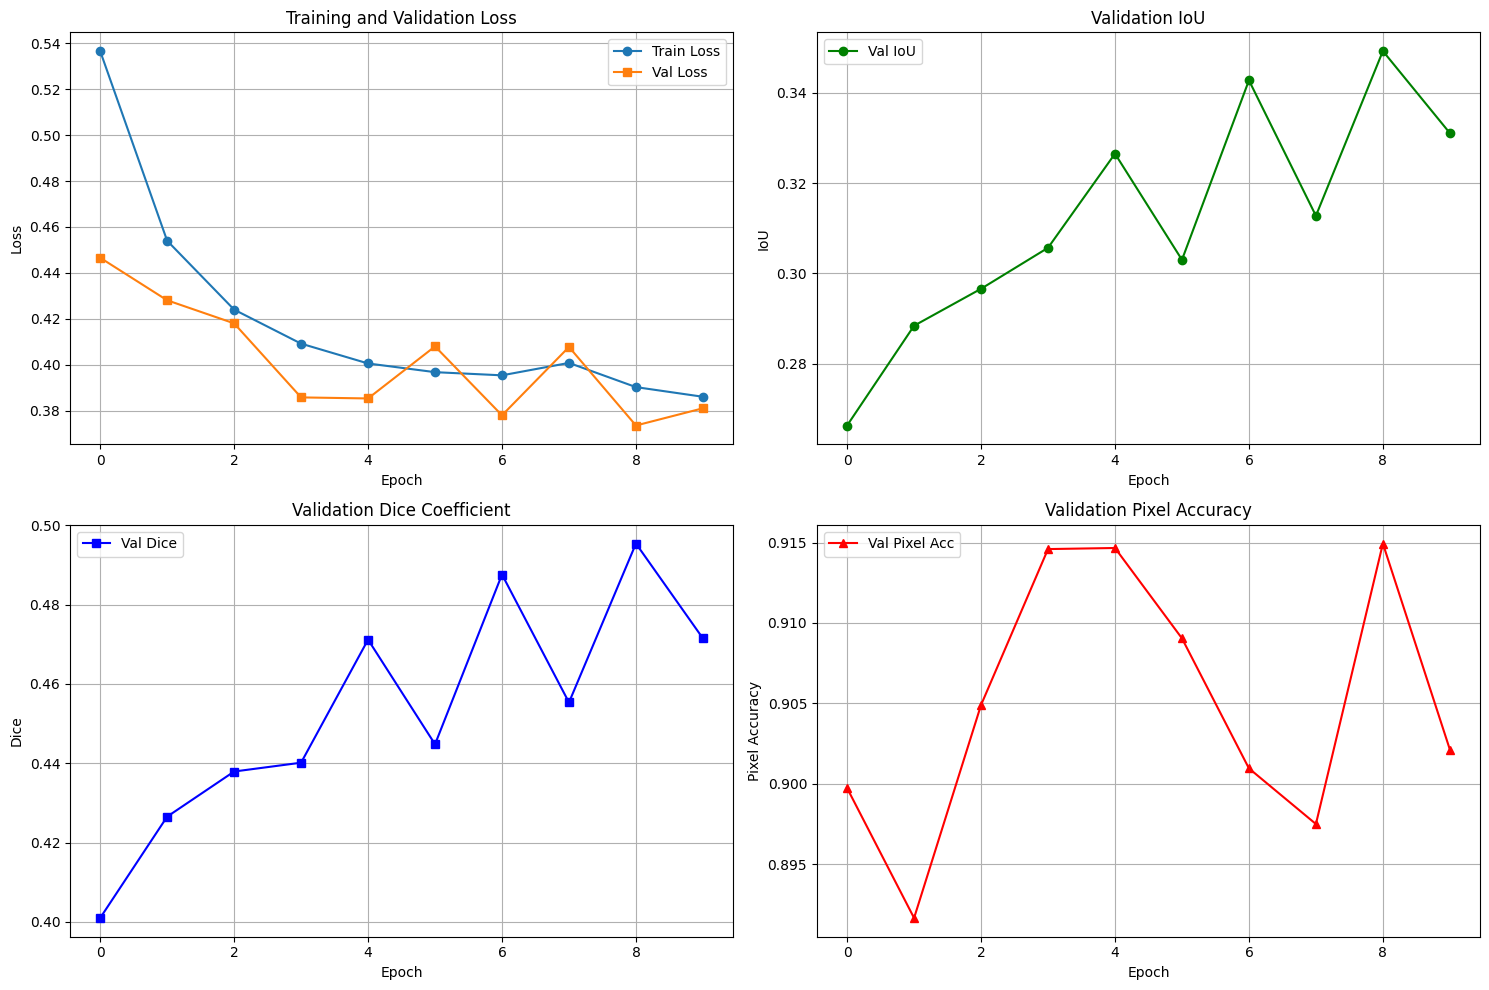

Best model loaded from epoch 9
Best validation IoU: 0.3492
Best validation Dice: 0.4954
Best validation Pixel Acc: 0.9149


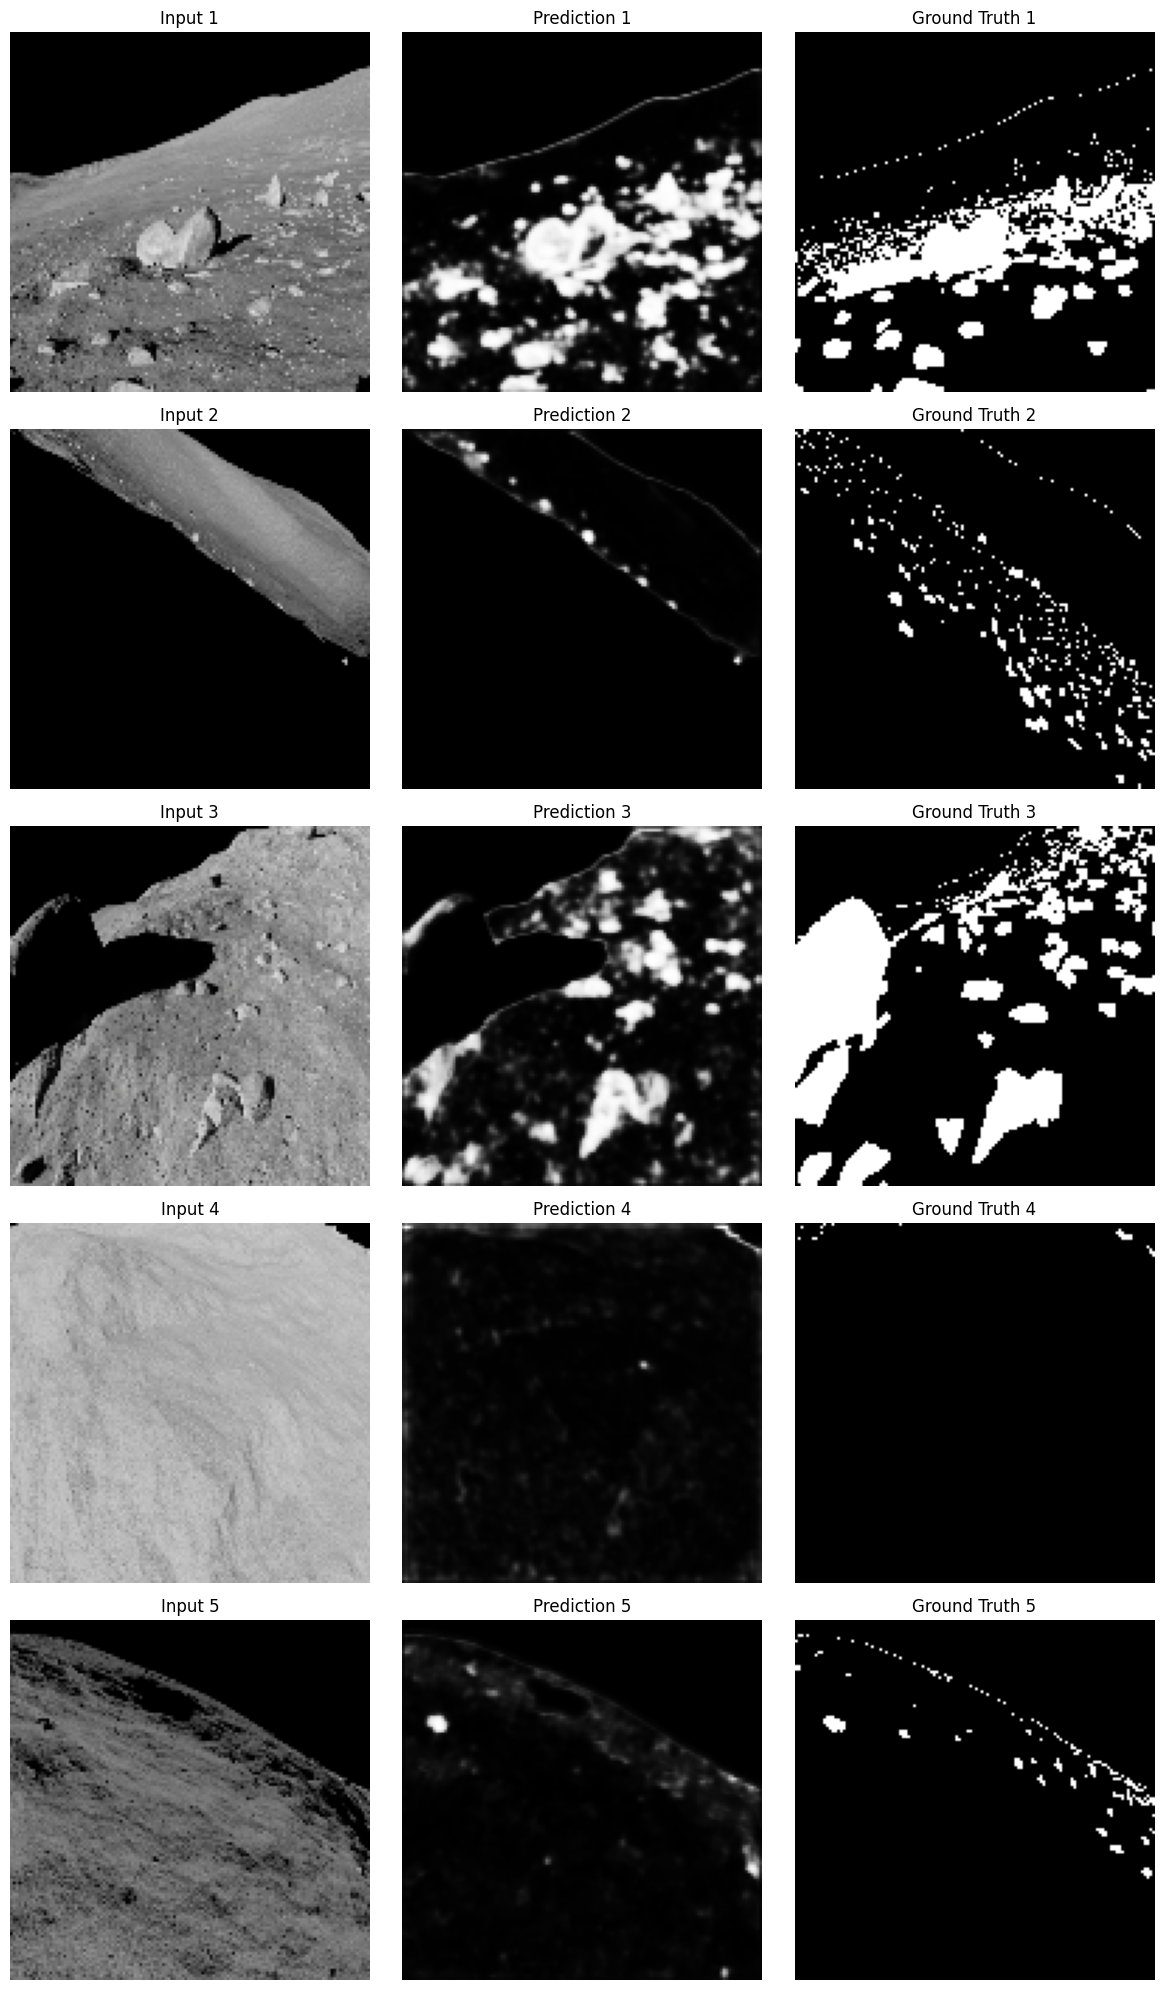

Final evaluation: 100%|██████████| 20/20 [00:04<00:00,  4.56it/s]


=== Part 2 Summary (Basic U-Net) ===
Best validation IoU: 0.3492
Best validation Dice: 0.4954
Best validation Pixel Acc: 0.9149
Final validation IoU: 0.3492
Final validation Dice: 0.4954
Final validation Pixel Acc: 0.9149


In [9]:
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

axes[0, 0].plot(history_unet_basic['train_loss'], label='Train Loss', marker='o')
axes[0, 0].plot(history_unet_basic['val_loss'], label='Val Loss', marker='s')
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].set_ylabel('Loss')
axes[0, 0].set_title('Training and Validation Loss')
axes[0, 0].legend()
axes[0, 0].grid(True)

axes[0, 1].plot(history_unet_basic['val_iou'], label='Val IoU', marker='o', color='green')
axes[0, 1].set_xlabel('Epoch')
axes[0, 1].set_ylabel('IoU')
axes[0, 1].set_title('Validation IoU')
axes[0, 1].legend()
axes[0, 1].grid(True)

axes[1, 0].plot(history_unet_basic['val_dice'], label='Val Dice', marker='s', color='blue')
axes[1, 0].set_xlabel('Epoch')
axes[1, 0].set_ylabel('Dice')
axes[1, 0].set_title('Validation Dice Coefficient')
axes[1, 0].legend()
axes[1, 0].grid(True)

axes[1, 1].plot(history_unet_basic['val_pixel_acc'], label='Val Pixel Acc', marker='^', color='red')
axes[1, 1].set_xlabel('Epoch')
axes[1, 1].set_ylabel('Pixel Accuracy')
axes[1, 1].set_title('Validation Pixel Accuracy')
axes[1, 1].legend()
axes[1, 1].grid(True)

plt.tight_layout()
plt.show()

checkpoint_unet = torch.load(os.path.join(CHECKPOINT_DIR, 'best_unet_basic.pth'))
model.load_state_dict(checkpoint_unet['model_state_dict'])
print(f"Best model loaded from epoch {checkpoint_unet['epoch']+1}")
print(f"Best validation IoU: {checkpoint_unet['val_iou']:.4f}")
print(f"Best validation Dice: {checkpoint_unet['val_dice']:.4f}")
print(f"Best validation Pixel Acc: {checkpoint_unet['val_pixel_acc']:.4f}")

model.eval()
fig, axes = plt.subplots(5, 3, figsize=(12, 20))

with torch.no_grad():
    for i in range(5):
        img, mask = val_dataset[i*10]
        img_tensor = img.unsqueeze(0).to(device)

        output = model(img_tensor)
        pred_mask = torch.sigmoid(output).squeeze().cpu()

        img_display = denormalize(img)
        img_display = img_display.permute(1, 2, 0).numpy()
        img_display = np.clip(img_display, 0, 1)

        axes[i, 0].imshow(img_display)
        axes[i, 0].set_title(f'Input {i+1}')
        axes[i, 0].axis('off')

        axes[i, 1].imshow(pred_mask, cmap='gray')
        axes[i, 1].set_title(f'Prediction {i+1}')
        axes[i, 1].axis('off')

        axes[i, 2].imshow(mask.squeeze(), cmap='gray')
        axes[i, 2].set_title(f'Ground Truth {i+1}')
        axes[i, 2].axis('off')

plt.tight_layout()
plt.show()

model.eval()
final_iou = 0.0
final_dice = 0.0
final_pixel_acc = 0.0
num_samples = 0

with torch.no_grad():
    for images, masks in tqdm(val_loader, desc='Final evaluation'):
        images, masks = images.to(device), masks.to(device)
        outputs = model(images)

        for i in range(outputs.size(0)):
            final_iou += calculate_iou(outputs[i], masks[i])
            final_dice += calculate_dice(outputs[i], masks[i])
            final_pixel_acc += calculate_pixel_accuracy(outputs[i], masks[i])
            num_samples += 1

final_iou /= num_samples
final_dice /= num_samples
final_pixel_acc /= num_samples

print('\n=== Part 2 Summary (Basic U-Net) ===')
print(f'Best validation IoU: {checkpoint_unet["val_iou"]:.4f}')
print(f'Best validation Dice: {checkpoint_unet["val_dice"]:.4f}')
print(f'Best validation Pixel Acc: {checkpoint_unet["val_pixel_acc"]:.4f}')
print(f'Final validation IoU: {final_iou:.4f}')
print(f'Final validation Dice: {final_dice:.4f}')
print(f'Final validation Pixel Acc: {final_pixel_acc:.4f}')


Часть 3. U-Net с бэкбоном из классификатора

3.1 Адаптация энкодера классификатора


In [21]:
import torch.nn.functional as F

class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels, **kwargs):
        super(ConvBlock, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, bias=False, **kwargs),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )
    def forward(self, x):
        return self.conv(x)

class ResidualBlock(nn.Module):
    def __init__(self, channels, dropout=0.1):
        super(ResidualBlock, self).__init__()
        self.block = nn.Sequential(
            ConvBlock(channels, channels, kernel_size=3, padding=1),
            nn.Conv2d(channels, channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(channels)
        )
        self.relu = nn.ReLU(inplace=True)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        return self.dropout(self.relu(x + self.block(x)))


class CustomClassifier(nn.Module):
    def __init__(self, num_classes=10, dropout=0.1):
        super(CustomClassifier, self).__init__()

        # Stage 1: 128x128 -> 64x64 (32 channels)
        self.stage1 = nn.Sequential(
            ConvBlock(3, 32, kernel_size=7, stride=2, padding=3),  # 128 -> 64
            ResidualBlock(32, dropout=dropout)
        )

        # Stage 2: 64x64 -> 32x32 (64 channels)
        self.stage2 = nn.Sequential(
            ConvBlock(32, 64, kernel_size=3, stride=2, padding=1),  # 64 -> 32
            ResidualBlock(64, dropout=dropout)
        )

        # Stage 3: 32x32 -> 16x16 (128 channels)
        self.stage3 = nn.Sequential(
            ConvBlock(64, 128, kernel_size=3, stride=2, padding=1),  # 32 -> 16
            ResidualBlock(128, dropout=dropout)
        )

        # Stage 4: 16x16 -> 8x8 (256 channels)
        self.stage4 = nn.Sequential(
            ConvBlock(128, 256, kernel_size=3, stride=2, padding=1),  # 16 -> 8
            ResidualBlock(256, dropout=dropout)
        )

        self.gap = nn.AdaptiveAvgPool2d(1)
        self.dropout_final = nn.Dropout(0.3)
        self.fc = nn.Linear(256, num_classes)

    def forward(self, x):
        x = self.stage1(x)
        x = self.stage2(x)
        x = self.stage3(x)
        x = self.stage4(x)
        x = self.gap(x)
        x = torch.flatten(x, 1)
        x = self.dropout_final(x)
        x = self.fc(x)
        return x


In [23]:
class EncoderFromClassifier(nn.Module):
    def __init__(self, classifier_model):
        super(EncoderFromClassifier, self).__init__()
        self.stage1 = classifier_model.stage1  # 64x64x64
        self.stage2 = classifier_model.stage2  # 32x32x128
        self.stage3 = classifier_model.stage3  # 16x16x256
        self.stage4 = classifier_model.stage4  # 8x8x512

    def forward(self, x):
        x1 = self.stage1(x)   # 64x64x64
        x2 = self.stage2(x1)  # 32x32x128
        x3 = self.stage3(x2)  # 16x16x256
        x4 = self.stage4(x3)  # 8x8x256
        return [x1, x2, x3, x4]

# Instantiate a new CustomClassifier model
classifier_model_instance = CustomClassifier(num_classes=num_classes, dropout=0.1).to(device)

# Load the classifier checkpoint into the new CustomClassifier instance
classifier_checkpoint = torch.load(os.path.join(CHECKPOINT_DIR, 'best_classifier.pth'))
classifier_model_instance.load_state_dict(classifier_checkpoint['model_state_dict'])
print(f"Classifier loaded from epoch {classifier_checkpoint['epoch']+1}")

encoder_from_classifier = EncoderFromClassifier(classifier_model_instance)

dummy_input = torch.randn(2, 3, 128, 128).to(device)
encoder_features = encoder_from_classifier(dummy_input)
print('\nEncoder feature maps:')
for i, feat in enumerate(encoder_features):
    print(f'  Level {i+1}: {feat.shape}')

Classifier loaded from epoch 1

Encoder feature maps:
  Level 1: torch.Size([2, 32, 64, 64])
  Level 2: torch.Size([2, 64, 32, 32])
  Level 3: torch.Size([2, 128, 16, 16])
  Level 4: torch.Size([2, 256, 8, 8])


In [22]:
# Define num_classes for the classifier (e.g., binary classification: moon present/absent)
num_classes = 2 # This can be adjusted based on the specific classification task if available

def compute_classification_labels(dataset, threshold_ratio=0.01):
    """
    Computes a binary classification label for each image based on the mask area.
    Label 1 if mask area / total pixels > threshold_ratio, else 0.
    """
    labels = []
    for i in tqdm(range(len(dataset)), desc="Computing classification labels"):
        _, mask = dataset[i]
        mask_area = mask.sum().item() # Sum of 1s in the binary mask
        total_pixels = mask.numel()
        if total_pixels == 0:
            labels.append(0) # Handle empty images if any
            continue
        area_ratio = mask_area / total_pixels
        labels.append(1 if area_ratio > threshold_ratio else 0)
    return labels

class MoonClassificationDataset(Dataset):
    def __init__(self, segmentation_dataset, labels):
        self.segmentation_dataset = segmentation_dataset
        self.labels = labels

    def __len__(self):
        return len(self.segmentation_dataset)

    def __getitem__(self, idx):
        image, _ = self.segmentation_dataset[idx] # We only need the image for classification
        label = self.labels[idx]
        return image, torch.tensor(label, dtype=torch.long)

# Compute labels and create classification datasets/loaders
train_classification_labels = compute_classification_labels(train_dataset)
val_classification_labels = compute_classification_labels(val_dataset)

train_class_dataset = MoonClassificationDataset(train_dataset, train_classification_labels)
val_class_dataset = MoonClassificationDataset(val_dataset, val_classification_labels)

class_train_loader = DataLoader(
    train_class_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=2
)

class_val_loader = DataLoader(
    val_class_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=2
)

def train_classifier(model, train_loader, val_loader, num_epochs=10, lr=0.001, model_name='classifier'):
    criterion = nn.CrossEntropyLoss() # For our pseudo-binary classification
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=1e-4)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=3)

    history = {
        'train_loss': [],
        'val_loss': [],
        'val_acc': []
    }

    best_val_acc = 0.0
    model.to(device)

    print(f"\nStarting training for {model_name} on {len(train_loader.dataset)} images.")

    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0
        train_correct = 0
        train_total = 0

        pbar = tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs} [Train Classifier]')
        for images, labels in pbar:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item() * images.size(0)

            _, predicted = torch.max(outputs.data, 1)
            train_total += labels.size(0)
            train_correct += (predicted == labels).sum().item()
            pbar.set_postfix({'loss': loss.item()})

        train_loss = train_loss / len(train_loader.dataset)
        train_acc = train_correct / train_total

        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0

        with torch.no_grad():
            for images, labels in tqdm(val_loader, desc=f'Epoch {epoch+1}/{num_epochs} [Val Classifier]'):
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)

                val_loss += loss.item() * images.size(0)
                _, predicted = torch.max(outputs.data, 1)
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()

        val_loss = val_loss / len(val_loader.dataset)
        val_acc = val_correct / val_total

        scheduler.step(val_acc)

        history['train_loss'].append(train_loss)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)

        print(f'Epoch {epoch+1}/{num_epochs}:')
        print(f'  Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}')
        print(f'  Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}')
        print(f'  LR: {optimizer.param_groups[0]['lr']:.6f}')

        if val_acc > best_val_acc:
            best_val_acc = val_acc
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'val_acc': val_acc,
            }, os.path.join(CHECKPOINT_DIR, f'best_{model_name}.pth'))
            print(f'Best classifier model saved! (Val Acc: {val_acc:.4f})')

        print()

    return history

# Instantiate and train the CustomClassifier
classifier_model_instance = CustomClassifier(num_classes=num_classes, dropout=0.1).to(device)
print(f"Total parameters in CustomClassifier: {sum(p.numel() for p in classifier_model_instance.parameters()):,}")

history_classifier = train_classifier(classifier_model_instance, class_train_loader, class_val_loader,
                                      num_epochs=5, lr=0.001, model_name='classifier')

classifier_checkpoint_path = os.path.join(CHECKPOINT_DIR, 'best_classifier.pth')
if os.path.exists(classifier_checkpoint_path):
    print(f"best_classifier.pth successfully created and found at: {classifier_checkpoint_path}")
else:
    print(f"Error: best_classifier.pth was not created at: {classifier_checkpoint_path}")


Computing classification labels: 100%|██████████| 200/200 [00:02<00:00, 75.07it/s]


Total parameters in CustomClassifier: 1,961,890

Starting training for classifier on 800 images.


Epoch 1/5 [Val Classifier]: 100%|██████████| 20/20 [00:01<00:00, 11.89it/s]


Epoch 1/5:
  Train Loss: 0.2675, Train Acc: 0.9250
  Val Loss: 0.3390, Val Acc: 0.9550
  LR: 0.001000
Best classifier model saved! (Val Acc: 0.9550)



Epoch 2/5 [Val Classifier]: 100%|██████████| 20/20 [00:01<00:00, 12.00it/s]


Epoch 2/5:
  Train Loss: 0.2370, Train Acc: 0.9437
  Val Loss: 0.2122, Val Acc: 0.9550
  LR: 0.001000



Epoch 3/5 [Val Classifier]: 100%|██████████| 20/20 [00:01<00:00, 12.18it/s]


Epoch 3/5:
  Train Loss: 0.2230, Train Acc: 0.9437
  Val Loss: 0.2106, Val Acc: 0.9550
  LR: 0.001000



Epoch 4/5 [Val Classifier]: 100%|██████████| 20/20 [00:01<00:00, 10.57it/s]


Epoch 4/5:
  Train Loss: 0.2181, Train Acc: 0.9437
  Val Loss: 0.2039, Val Acc: 0.9550
  LR: 0.001000



Epoch 5/5 [Val Classifier]: 100%|██████████| 20/20 [00:01<00:00, 10.38it/s]

Epoch 5/5:
  Train Loss: 0.2208, Train Acc: 0.9437
  Val Loss: 0.1998, Val Acc: 0.9550
  LR: 0.000500

best_classifier.pth successfully created and found at: /content/checkpoints/best_classifier.pth


3.2 U-Net с предобученным бэкбоном


In [24]:
class UNetWithBackbone(nn.Module):

    def __init__(self, encoder_from_classifier, out_channels=1, pretrained=True):
        super(UNetWithBackbone, self).__init__()

        self.encoder1 = encoder_from_classifier.stage1 # Out: 32 channels, 64x64
        self.encoder2 = encoder_from_classifier.stage2 # Out: 64 channels, 32x32
        self.encoder3 = encoder_from_classifier.stage3 # Out: 128 channels, 16x16
        self.encoder4 = encoder_from_classifier.stage4 # Out: 256 channels, 8x8

        self.upconv4 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2) # Output: 128 channels, 16x16
        self.decoder4 = DoubleConv(128 + 128, 128) # Output: 128 channels, 16x16

        self.upconv3 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2) # Output: 64 channels, 32x32
        self.decoder3 = DoubleConv(64 + 64, 64) # Output: 64 channels, 32x32

        self.upconv2 = nn.ConvTranspose2d(64, 32, kernel_size=2, stride=2) # Output: 32 channels, 64x64
        self.decoder2 = DoubleConv(32 + 32, 32) # Output: 32 channels, 64x64

        self.upconv1 = nn.ConvTranspose2d(32, 32, kernel_size=2, stride=2) # Output: 32 channels, 128x128
        self.decoder1 = DoubleConv(32, 32) # Output: 32 channels, 128x128

        self.out_conv = nn.Conv2d(32, out_channels, kernel_size=1)

    def forward(self, x):
        # Encoder
        enc1 = self.encoder1(x)  # (B, 32, 64, 64)
        enc2 = self.encoder2(enc1) # (B, 64, 32, 32)
        enc3 = self.encoder3(enc2) # (B, 128, 16, 16)
        enc4 = self.encoder4(enc3) # (B, 256, 8, 8)

        x = self.upconv4(enc4) # (B, 128, 16, 16)
        x = torch.cat([x, enc3], dim=1) # (B, 128+128=256, 16, 16)
        x = self.decoder4(x) # (B, 128, 16, 16)

        x = self.upconv3(x) # (B, 64, 32, 32)
        x = torch.cat([x, enc2], dim=1) # (B, 64+64=128, 32, 32)
        x = self.decoder3(x) # (B, 64, 32, 32)

        x = self.upconv2(x) # (B, 32, 64, 64)
        x = torch.cat([x, enc1], dim=1) # (B, 32+32=64, 64, 64)
        x = self.decoder2(x) # (B, 32, 64, 64)

        x = self.upconv1(x) # (B, 32, 128, 128)
        x = self.decoder1(x) # (B, 32, 128, 128)

        out = self.out_conv(x) # (B, out_channels, 128, 128)
        return out

    def freeze_encoder(self):
        for param in self.encoder1.parameters(): param.requires_grad = False
        for param in self.encoder2.parameters(): param.requires_grad = False
        for param in self.encoder3.parameters(): param.requires_grad = False
        for param in self.encoder4.parameters(): param.requires_grad = False
        print('Encoder frozen')

    def unfreeze_encoder(self):
        for param in self.encoder1.parameters(): param.requires_grad = True
        for param in self.encoder2.parameters(): param.requires_grad = True
        for param in self.encoder3.parameters(): param.requires_grad = True
        for param in self.encoder4.parameters(): param.requires_grad = True
        print('Encoder unfrozen')

unet_with_backbone = UNetWithBackbone(encoder_from_classifier, out_channels=1, pretrained=True).to(device)

total_params_backbone = sum(p.numel() for p in unet_with_backbone.parameters())
trainable_params_backbone = sum(p.numel() for p in unet_with_backbone.parameters() if p.requires_grad)

print(f'\nU-Net with Backbone parameters: {total_params_backbone:,} ({total_params_backbone/1e6:.2f}M)')
print(f'Trainable parameters: {trainable_params_backbone:,} ({trainable_params_backbone/1e6:.2f}M)')

dummy_input = torch.randn(2, 3, 128, 128).to(device) # Changed input size to 128x128
dummy_output = unet_with_backbone(dummy_input)
print(f'\nInput shape: {dummy_input.shape}')
print(f'Output shape: {dummy_output.shape}')



U-Net with Backbone parameters: 2,738,369 (2.74M)
Trainable parameters: 2,738,369 (2.74M)

Input shape: torch.Size([2, 3, 128, 128])
Output shape: torch.Size([2, 1, 128, 128])


3.3 Обучение с замороженным энкодером


In [25]:
unet_with_backbone.freeze_encoder()

trainable_params_frozen = sum(p.numel() for p in unet_with_backbone.parameters() if p.requires_grad)
print(f'Trainable parameters (frozen encoder): {trainable_params_frozen:,} ({trainable_params_frozen/1e6:.2f}M)')

history_frozen = train_unet(unet_with_backbone, train_loader, val_loader,
                            num_epochs=10, lr=0.001, model_name='unet_frozen')

Encoder frozen
Trainable parameters (frozen encoder): 776,993 (0.78M)


Epoch 1/10 [Val]: 100%|██████████| 20/20 [00:03<00:00,  6.53it/s]


Epoch 1/10:
  Train Loss: 0.6296
  Val Loss: 0.5522
  Val IoU: 0.1908, Dice: 0.3033, Pixel Acc: 0.8664
  LR: 0.001000
Best model saved! (Val IoU: 0.1908)



Epoch 2/10 [Val]: 100%|██████████| 20/20 [00:02<00:00,  7.98it/s]


Epoch 2/10:
  Train Loss: 0.5396
  Val Loss: 0.4910
  Val IoU: 0.2343, Dice: 0.3591, Pixel Acc: 0.8742
  LR: 0.001000
Best model saved! (Val IoU: 0.2343)



Epoch 3/10 [Val]: 100%|██████████| 20/20 [00:02<00:00,  7.72it/s]


Epoch 3/10:
  Train Loss: 0.5180
  Val Loss: 0.4729
  Val IoU: 0.2151, Dice: 0.3353, Pixel Acc: 0.8908
  LR: 0.001000



Epoch 4/10 [Val]: 100%|██████████| 20/20 [00:02<00:00,  7.91it/s]


Epoch 4/10:
  Train Loss: 0.5009
  Val Loss: 0.4879
  Val IoU: 0.1928, Dice: 0.3060, Pixel Acc: 0.8916
  LR: 0.001000



Epoch 5/10 [Val]: 100%|██████████| 20/20 [00:02<00:00,  6.88it/s]


Epoch 5/10:
  Train Loss: 0.4925
  Val Loss: 0.4570
  Val IoU: 0.2345, Dice: 0.3597, Pixel Acc: 0.8895
  LR: 0.001000
Best model saved! (Val IoU: 0.2345)



Epoch 6/10 [Val]: 100%|██████████| 20/20 [00:02<00:00,  7.88it/s]


Epoch 6/10:
  Train Loss: 0.4902
  Val Loss: 0.4701
  Val IoU: 0.2068, Dice: 0.3233, Pixel Acc: 0.8961
  LR: 0.001000



Epoch 7/10 [Val]: 100%|██████████| 20/20 [00:02<00:00,  7.94it/s]


Epoch 7/10:
  Train Loss: 0.4929
  Val Loss: 0.4567
  Val IoU: 0.2373, Dice: 0.3634, Pixel Acc: 0.8883
  LR: 0.001000
Best model saved! (Val IoU: 0.2373)



Epoch 8/10 [Val]: 100%|██████████| 20/20 [00:03<00:00,  6.51it/s]


Epoch 8/10:
  Train Loss: 0.4855
  Val Loss: 0.4694
  Val IoU: 0.2536, Dice: 0.3834, Pixel Acc: 0.8754
  LR: 0.001000
Best model saved! (Val IoU: 0.2536)



Epoch 9/10 [Val]: 100%|██████████| 20/20 [00:02<00:00,  7.60it/s]


Epoch 9/10:
  Train Loss: 0.4869
  Val Loss: 0.4543
  Val IoU: 0.2500, Dice: 0.3781, Pixel Acc: 0.8887
  LR: 0.001000



Epoch 10/10 [Val]: 100%|██████████| 20/20 [00:02<00:00,  7.88it/s]

Epoch 10/10:
  Train Loss: 0.4884
  Val Loss: 0.4580
  Val IoU: 0.2521, Dice: 0.3821, Pixel Acc: 0.8803
  LR: 0.001000



3.4 Fine-tuning с разморозкой энкодера


In [26]:
checkpoint_frozen = torch.load(os.path.join(CHECKPOINT_DIR, 'best_unet_frozen.pth'))
unet_with_backbone.load_state_dict(checkpoint_frozen['model_state_dict'])
print(f"Best frozen model loaded from epoch {checkpoint_frozen['epoch']+1}")
print(f"Best validation IoU (frozen): {checkpoint_frozen['val_iou']:.4f}")

unet_with_backbone.unfreeze_encoder()

trainable_params_unfrozen = sum(p.numel() for p in unet_with_backbone.parameters() if p.requires_grad)
print(f'Trainable parameters (unfrozen encoder): {trainable_params_unfrozen:,} ({trainable_params_unfrozen/1e6:.2f}M)')

print('\n=== Fine-tuning U-Net with Unfrozen Encoder ===')
history_finetuned = train_unet(unet_with_backbone, train_loader, val_loader,
                               num_epochs=10, lr=0.0001, model_name='unet_finetuned')
print('Fine-tuning complete!')

Best frozen model loaded from epoch 8
Best validation IoU (frozen): 0.2536
Encoder unfrozen
Trainable parameters (unfrozen encoder): 2,738,369 (2.74M)

=== Fine-tuning U-Net with Unfrozen Encoder ===


Epoch 1/10 [Val]: 100%|██████████| 20/20 [00:02<00:00,  7.07it/s]


Epoch 1/10:
  Train Loss: 0.4800
  Val Loss: 0.4447
  Val IoU: 0.2638, Dice: 0.3967, Pixel Acc: 0.8886
  LR: 0.000100
Best model saved! (Val IoU: 0.2638)



Epoch 2/10 [Val]: 100%|██████████| 20/20 [00:02<00:00,  7.91it/s]


Epoch 2/10:
  Train Loss: 0.4644
  Val Loss: 0.4321
  Val IoU: 0.2654, Dice: 0.3988, Pixel Acc: 0.8955
  LR: 0.000100
Best model saved! (Val IoU: 0.2654)



Epoch 3/10 [Val]: 100%|██████████| 20/20 [00:02<00:00,  7.74it/s]


Epoch 3/10:
  Train Loss: 0.4664
  Val Loss: 0.4417
  Val IoU: 0.2643, Dice: 0.3980, Pixel Acc: 0.8889
  LR: 0.000100



Epoch 4/10 [Val]: 100%|██████████| 20/20 [00:02<00:00,  7.72it/s]


Epoch 4/10:
  Train Loss: 0.4621
  Val Loss: 0.4504
  Val IoU: 0.2478, Dice: 0.3783, Pixel Acc: 0.8947
  LR: 0.000100



Epoch 5/10 [Val]: 100%|██████████| 20/20 [00:02<00:00,  7.97it/s]


Epoch 5/10:
  Train Loss: 0.4582
  Val Loss: 0.4292
  Val IoU: 0.2715, Dice: 0.4070, Pixel Acc: 0.8959
  LR: 0.000100
Best model saved! (Val IoU: 0.2715)



Epoch 6/10 [Val]: 100%|██████████| 20/20 [00:02<00:00,  7.27it/s]


Epoch 6/10:
  Train Loss: 0.4485
  Val Loss: 0.4219
  Val IoU: 0.2881, Dice: 0.4251, Pixel Acc: 0.8899
  LR: 0.000100
Best model saved! (Val IoU: 0.2881)



Epoch 7/10 [Val]: 100%|██████████| 20/20 [00:02<00:00,  7.97it/s]


Epoch 7/10:
  Train Loss: 0.4445
  Val Loss: 0.4323
  Val IoU: 0.2923, Dice: 0.4293, Pixel Acc: 0.8798
  LR: 0.000100
Best model saved! (Val IoU: 0.2923)



Epoch 8/10 [Val]: 100%|██████████| 20/20 [00:02<00:00,  7.94it/s]


Epoch 8/10:
  Train Loss: 0.4434
  Val Loss: 0.4129
  Val IoU: 0.2950, Dice: 0.4319, Pixel Acc: 0.8935
  LR: 0.000100
Best model saved! (Val IoU: 0.2950)



Epoch 9/10 [Val]: 100%|██████████| 20/20 [00:02<00:00,  6.69it/s]


Epoch 9/10:
  Train Loss: 0.4418
  Val Loss: 0.4063
  Val IoU: 0.2960, Dice: 0.4349, Pixel Acc: 0.9004
  LR: 0.000100
Best model saved! (Val IoU: 0.2960)



Epoch 10/10 [Val]: 100%|██████████| 20/20 [00:02<00:00,  8.03it/s]

Epoch 10/10:
  Train Loss: 0.4340
  Val Loss: 0.4131
  Val IoU: 0.2904, Dice: 0.4286, Pixel Acc: 0.8976
  LR: 0.000100

Fine-tuning complete!


3.5 Результаты и визуализация


Best fine-tuned model loaded from epoch 9
Best validation IoU (fine-tuned): 0.2960


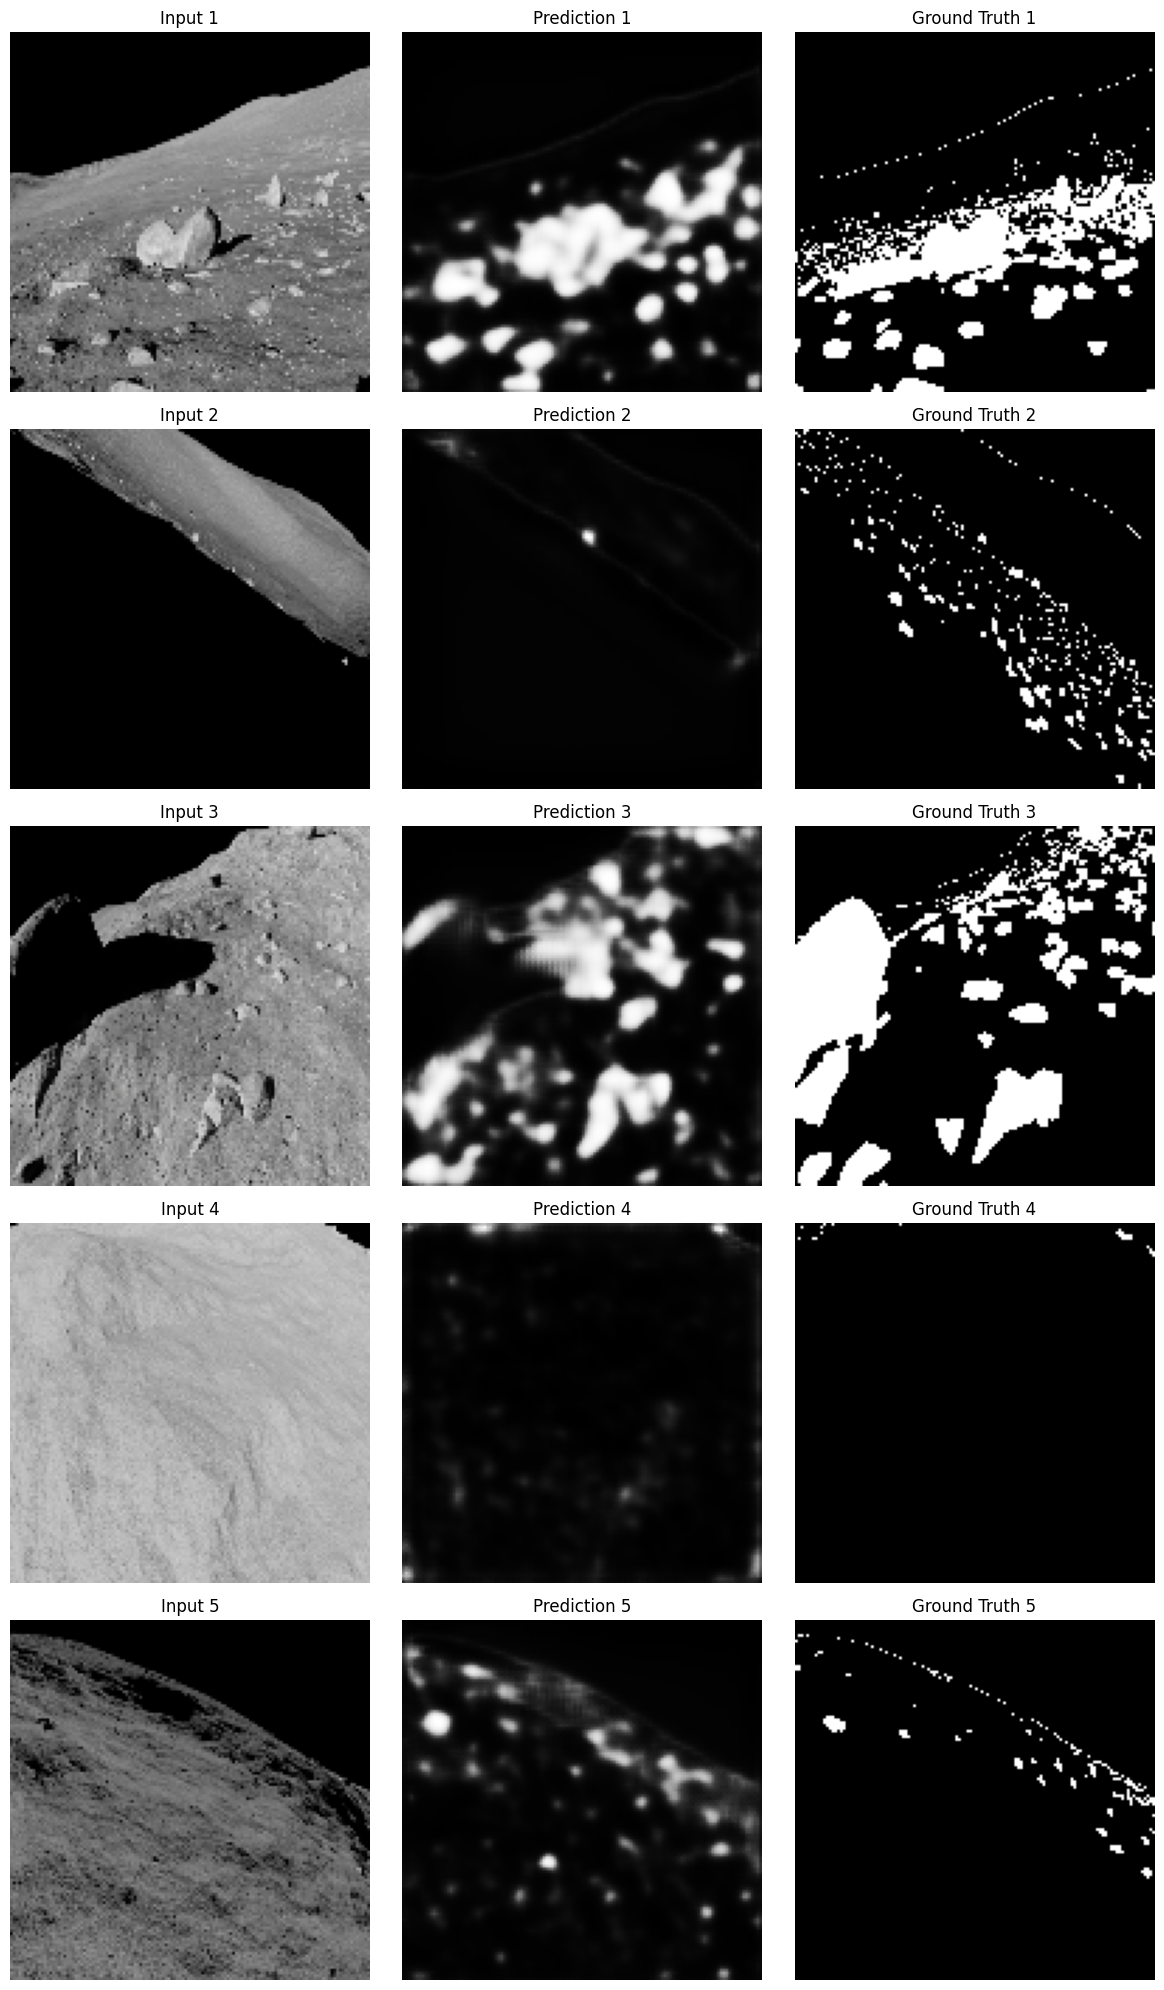

Final evaluation (backbone): 100%|██████████| 20/20 [00:02<00:00,  7.34it/s]


=== Part 3 Summary (U-Net with Backbone) ===
Model parameters: 2.74M
Best validation IoU (frozen): 0.2536
Best validation IoU (fine-tuned): 0.2960
Final validation IoU: 0.2960
Final validation Dice: 0.4349
Final validation Pixel Acc: 0.9004


In [27]:
checkpoint_finetuned = torch.load(os.path.join(CHECKPOINT_DIR, 'best_unet_finetuned.pth'))
unet_with_backbone.load_state_dict(checkpoint_finetuned['model_state_dict'])
print(f"Best fine-tuned model loaded from epoch {checkpoint_finetuned['epoch']+1}")
print(f"Best validation IoU (fine-tuned): {checkpoint_finetuned['val_iou']:.4f}")

unet_with_backbone.eval()
fig, axes = plt.subplots(5, 3, figsize=(12, 20))

with torch.no_grad():
    for i in range(5):
        img, mask = val_dataset[i*10]
        img_tensor = img.unsqueeze(0).to(device)

        output = unet_with_backbone(img_tensor)
        pred_mask = torch.sigmoid(output).squeeze().cpu()

        img_display = denormalize(img)
        img_display = img_display.permute(1, 2, 0).numpy()
        img_display = np.clip(img_display, 0, 1)

        axes[i, 0].imshow(img_display)
        axes[i, 0].set_title(f'Input {i+1}')
        axes[i, 0].axis('off')

        axes[i, 1].imshow(pred_mask, cmap='gray')
        axes[i, 1].set_title(f'Prediction {i+1}')
        axes[i, 1].axis('off')

        axes[i, 2].imshow(mask.squeeze(), cmap='gray')
        axes[i, 2].set_title(f'Ground Truth {i+1}')
        axes[i, 2].axis('off')

plt.tight_layout()
plt.show()

unet_with_backbone.eval()
final_iou_backbone = 0.0
final_dice_backbone = 0.0
final_pixel_acc_backbone = 0.0
num_samples = 0

with torch.no_grad():
    for images, masks in tqdm(val_loader, desc='Final evaluation (backbone)'):
        images, masks = images.to(device), masks.to(device)
        outputs = unet_with_backbone(images)

        for i in range(outputs.size(0)):
            final_iou_backbone += calculate_iou(outputs[i], masks[i])
            final_dice_backbone += calculate_dice(outputs[i], masks[i])
            final_pixel_acc_backbone += calculate_pixel_accuracy(outputs[i], masks[i])
            num_samples += 1

final_iou_backbone /= num_samples
final_dice_backbone /= num_samples
final_pixel_acc_backbone /= num_samples

print('\n=== Part 3 Summary (U-Net with Backbone) ===')
print(f'Model parameters: {total_params_backbone/1e6:.2f}M')
print(f'Best validation IoU (frozen): {checkpoint_frozen["val_iou"]:.4f}')
print(f'Best validation IoU (fine-tuned): {checkpoint_finetuned["val_iou"]:.4f}')
print(f'Final validation IoU: {final_iou_backbone:.4f}')
print(f'Final validation Dice: {final_dice_backbone:.4f}')
print(f'Final validation Pixel Acc: {final_pixel_acc_backbone:.4f}')

Сравнительная таблица метрик


Параметров: 31,043,521
Уровней encoder: 4
Конфигурация каналов: [64, 128, 256, 512]

COMPARISON TABLE: Basic U-Net vs U-Net with Classifier Backbone
                     Model Parameters (M) Trainable Params (M) Best Val IoU Best Val Dice Best Val Pixel Acc Final Val IoU Final Val Dice Final Val Pixel Acc
               Basic U-Net          31.04                31.04       0.3492        0.4954             0.9149        0.3492         0.4954              0.9149
    U-Net + Frozen Encoder           2.74                 0.78       0.2536        0.3834             0.8754           N/A            N/A                 N/A
U-Net + Fine-tuned Encoder           2.74                 2.74       0.2960        0.4349             0.9004        0.2960         0.4349              0.9004


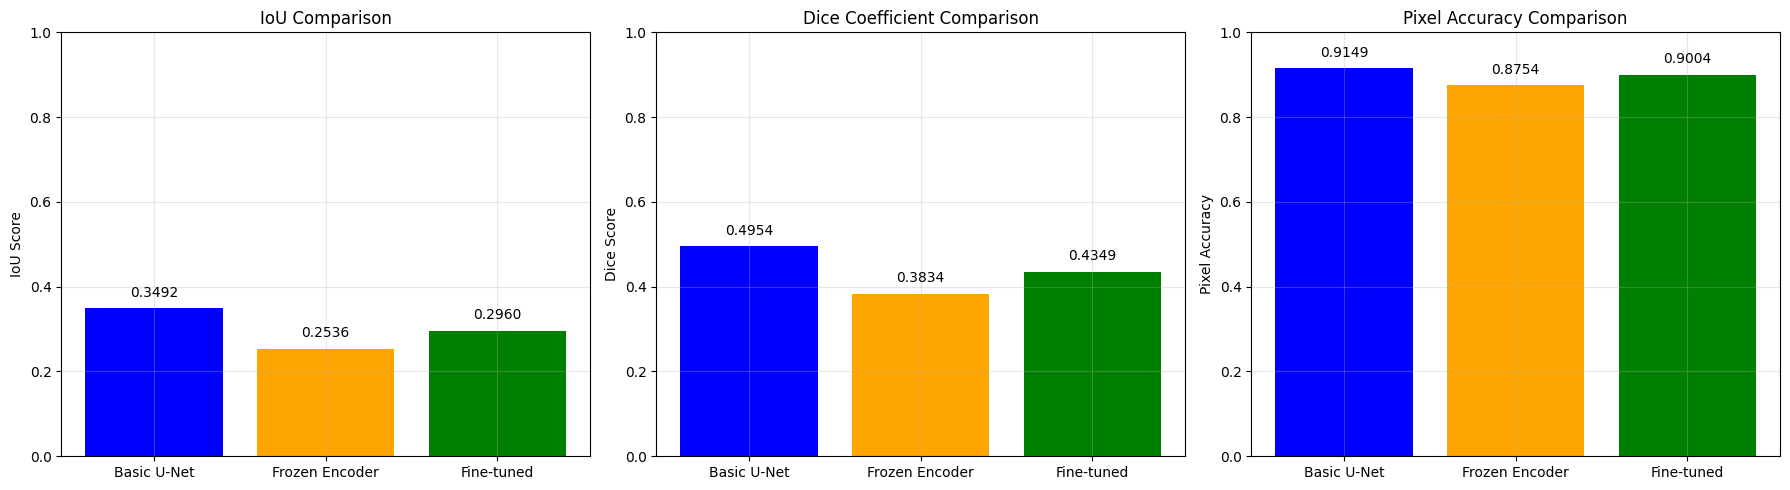

In [31]:
# Re-instantiate the basic UNet model and calculate its parameters
# This assumes UNet, DoubleConv, and device are defined in previous cells and are in scope.
model_basic_unet = UNet(in_channels=3, out_channels=1, features=[64, 128, 256, 512])
total_params_unet = sum(p.numel() for p in model_basic_unet.parameters())

comparison_data = {
    'Model': [
        'Basic U-Net',
        'U-Net + Frozen Encoder',
        'U-Net + Fine-tuned Encoder'
    ],
    'Parameters (M)': [
        f'{total_params_unet/1e6:.2f}',
        f'{total_params_backbone/1e6:.2f}',
        f'{total_params_backbone/1e6:.2f}'
    ],
    'Trainable Params (M)': [
        f'{total_params_unet/1e6:.2f}',
        f'{trainable_params_frozen/1e6:.2f}',
        f'{trainable_params_unfrozen/1e6:.2f}'
    ],
    'Best Val IoU': [
        f'{checkpoint_unet["val_iou"]:.4f}',
        f'{checkpoint_frozen["val_iou"]:.4f}',
        f'{checkpoint_finetuned["val_iou"]:.4f}'
    ],
    'Best Val Dice': [
        f'{checkpoint_unet["val_dice"]:.4f}',
        f'{checkpoint_frozen["val_dice"]:.4f}',
        f'{checkpoint_finetuned["val_dice"]:.4f}'
    ],
    'Best Val Pixel Acc': [
        f'{checkpoint_unet["val_pixel_acc"]:.4f}',
        f'{checkpoint_frozen["val_pixel_acc"]:.4f}',
        f'{checkpoint_finetuned["val_pixel_acc"]:.4f}'
    ],
    'Final Val IoU': [
        f'{final_iou:.4f}',
        'N/A',
        f'{final_iou_backbone:.4f}'
    ],
    'Final Val Dice': [
        f'{final_dice:.4f}',
        'N/A',
        f'{final_dice_backbone:.4f}'
    ],
    'Final Val Pixel Acc': [
        f'{final_pixel_acc:.4f}',
        'N/A',
        f'{final_pixel_acc_backbone:.4f}'
    ]
}

df_comparison = pd.DataFrame(comparison_data)
print('\n' + '='*80)
print('COMPARISON TABLE: Basic U-Net vs U-Net with Classifier Backbone')
print('='*80)
print(df_comparison.to_string(index=False))
print('='*80)

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

models = ['Basic U-Net', 'Frozen Encoder', 'Fine-tuned']
iou_scores = [
    checkpoint_unet["val_iou"],
    checkpoint_frozen["val_iou"],
    checkpoint_finetuned["val_iou"]
]
dice_scores = [
    checkpoint_unet["val_dice"],
    checkpoint_frozen["val_dice"],
    checkpoint_finetuned["val_dice"]
]
pixel_acc_scores = [
    checkpoint_unet["val_pixel_acc"],
    checkpoint_frozen["val_pixel_acc"],
    checkpoint_finetuned["val_pixel_acc"]
]

axes[0].bar(models, iou_scores, color=['blue', 'orange', 'green'])
axes[0].set_ylabel('IoU Score')
axes[0].set_title('IoU Comparison')
axes[0].set_ylim([0, 1])
axes[0].grid(True, alpha=0.3)
for i, v in enumerate(iou_scores):
    axes[0].text(i, v + 0.02, f'{v:.4f}', ha='center', va='bottom')

axes[1].bar(models, dice_scores, color=['blue', 'orange', 'green'])
axes[1].set_ylabel('Dice Score')
axes[1].set_title('Dice Coefficient Comparison')
axes[1].set_ylim([0, 1])
axes[1].grid(True, alpha=0.3)
for i, v in enumerate(dice_scores):
    axes[1].text(i, v + 0.02, f'{v:.4f}', ha='center', va='bottom')

axes[2].bar(models, pixel_acc_scores, color=['blue', 'orange', 'green'])
axes[2].set_ylabel('Pixel Accuracy')
axes[2].set_title('Pixel Accuracy Comparison')
axes[2].set_ylim([0, 1])
axes[2].grid(True, alpha=0.3)
for i, v in enumerate(pixel_acc_scores):
    axes[2].text(i, v + 0.02, f'{v:.4f}', ha='center', va='bottom')

plt.tight_layout()
plt.show()

В данном случае лучше всего себя показала обычная U-NET, что можно объяснить:

Разным доменом при обучении классификтора и при обучении UNET, а также коротким временем обучения